## 1. Подготовка данных и модели

Импортируем необходимые библиотеки

In [1]:
%%capture

import torch
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from fastai.vision import untar_data, URLs, get_image_files

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

%matplotlib inline

Готовим GPU для вычислений

In [2]:
device = torch.device("cuda:0")

Загружаем датасет Imagenette

In [3]:
path = untar_data(URLs.IMAGENETTE)

Выгружаем из него тренировочные и валидационные данные

In [4]:
batch_size = 256

train_data = ImageFolder(
    path/'train', 
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

val_data = ImageFolder(
    path/'val', 
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)

Загрузим с сайта датасета названия классов, представленных в нем

In [5]:
description = 'tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute'
classes = description.split(', ')

Посмотрим на данные

Training examples: 9469
Validation examples: 3925


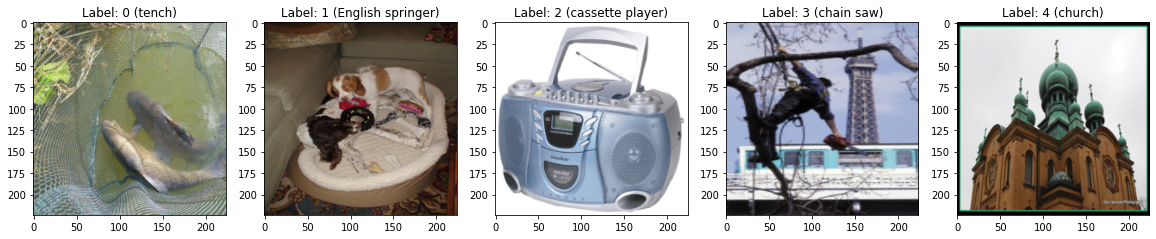

In [6]:
def plot_image(img, label):
    i = img if len(img.shape) == 3 else img[0]
    l = int(label)
    plt.title(f'Label: {l} ({classes[l]})')
    plt.imshow(np.transpose(i, (1, 2, 0)))


print(f'Training examples: {len(train_data)}')
print(f'Validation examples: {len(val_data)}')
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plot_image(*train_data[i * 1000])

Загрузим предобученную модель

In [7]:
model = resnet18(pretrained=True)

Заменим последний слой на Fully Connected с 10 выходами (в оригинальной модели их 1000). Также укажем, что все остальные слои тренировать не нужно.

In [8]:
%%capture

for param in model.parameters():
    param.requires_grad = False

fc_input = model.fc.in_features
model.fc = torch.nn.Linear(fc_input, 10)
model.type(torch.cuda.FloatTensor)

model.to(device)

## 2. Тренировка

Создадим функции для тренировки и оценки модели


In [9]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    """
    A function to train the model

    Parameters:
    model:        a model to train
    train_loader: data loader with training examples
    val_loader:   data loader with validation examples
    loss:         loss function
    optimizer:    optimization algorithm
    num_epochs:   number of epochs in training
    """    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        print(f'Average loss: {ave_loss}, Train accuracy: {train_accuracy}, Val accuracy: {val_accuracy}')


def evaluate_model(model, loader):
    """
    A function to evaluate the model

    Parameters:
    model:  the model to evaluate
    loader: data loader with evaluation examples

    Returns:
    ground_truth: a tensor with ground truth labels from loader
    prediction:   a tensor with model predictions on loader's data
    """
    model.eval()
    ground_truth = np.array([])
    prediction = np.array([])
    for x, y in loader:
        x_gpu = x.to(device)
        ground_truth = np.concatenate((ground_truth, y), axis=None)
        pred = model(x_gpu).cpu()
        _, indices = torch.max(pred, 1)
        prediction = np.concatenate((prediction, indices), axis=None)
    return ground_truth, prediction


def compute_accuracy(model, loader):
    """
    A function to compute accuracy on dataset

    Parameters:
    model:  the model to evaluate
    loader: data loader with evaluation examples

    Returns:
    accuracy: accuracy metric value
    """
    ground_truth, prediction = evaluate_model(model, loader)
    correct = np.sum(ground_truth == prediction)
    total = ground_truth.shape[0]
    return correct / total

Тренируем модель с кросс-энтропийной функцией потерь и оптимизатором Adam


In [10]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_model(model, train_loader, val_loader, loss, optimizer, 2)

Average loss: 1.1535192728042603, Train accuracy: 0.7451684443975076, Val accuracy: 0.9556687898089172
Average loss: 0.26071101427078247, Train accuracy: 0.9645157883620235, Val accuracy: 0.9671337579617835


Модель натренирована

## 3. Расчет точности

Рассчитаем confusion matrix

In [11]:
ground_truth, prediction = evaluate_model(model, val_loader)

In [12]:
matrix = confusion_matrix(ground_truth, prediction)

# Визуализируем полученную матрицу

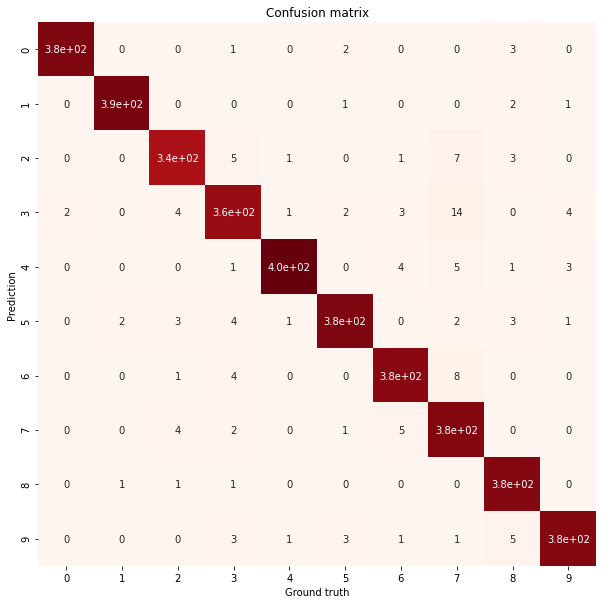

In [13]:
plt.figure(figsize=(10, 10))
plt.title('Confusion matrix')
ax = sns.heatmap(matrix.T, cmap='Reds', annot=True, cbar=False)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.show()

Рассчитаем точность по классам на основе матрицы

In [14]:
def compute_classes_accuracy(matrix):
    result = np.zeros((10,))
    for c in range(10):
        result[c] = matrix[c][c] / np.sum(matrix[c])
    return result

In [15]:
classes_accuracy = compute_classes_accuracy(matrix)

Отсортируем классы по возрастанию точности

In [16]:
top_classes = sorted(range(10), key=lambda i: classes_accuracy[i])

Топ-3 лучших и худших по точности классов

In [17]:
print('Top 3 best accuracies:')
for c in reversed(top_classes[-3:]):
    print(f'Class: {c} ({classes[c]}), Accuracy: {classes_accuracy[c]}')
print('Top 3 worst accuracies:')
for c in top_classes[:3]:
    print(f'Class: {c} ({classes[c]}), Accuracy: {classes_accuracy[c]}')

Top 3 best accuracies:
Class: 0 (tench), Accuracy: 0.9948320413436692
Class: 1 (English springer), Accuracy: 0.9924050632911392
Class: 4 (church), Accuracy: 0.9902200488997555
Top 3 worst accuracies:
Class: 7 (gas pump), Accuracy: 0.9116945107398569
Class: 3 (chain saw), Accuracy: 0.9455958549222798
Class: 8 (golf ball), Accuracy: 0.9573934837092731


## 4. Grad-CAM

Установим пакет GradCAM для pytorch

In [18]:
%%capture

!pip3 install pytorch-gradcam

Импортируем из него необходимые элементы: сам GradCAM и утилиту для визуализации

In [19]:
from gradcam import GradCAM
from gradcam.utils import visualize_cam

Создадим GradCAM для нашей модели, для работы понадобится восстановить свойство requires_grad у параметров модели

In [20]:
model.eval()
cam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')
for param in model.parameters():
    param.requires_grad = True

Выберем изображение из валидационного датасета

In [21]:
batch_x, batch_y = next(iter(val_loader))
x, y = batch_x[:1], batch_y[:1]

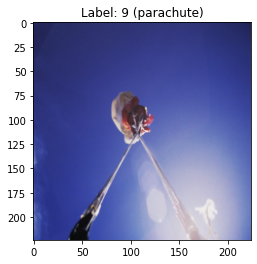

In [22]:
plot_image(x, y)

In [23]:
x_gpu = x.to(device)
y_gpu = y.to(device)

Визуализируем отклики модели на пикселях изображения с помощью GradCAM

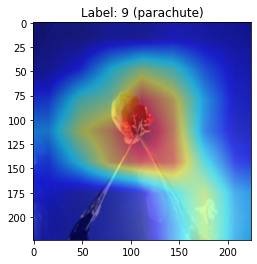

In [24]:
%%capture --no-display

def plot_gradcam(image, label, gradcam):
    mask, _ = gradcam(image, class_idx=label)
    heatmap, result = visualize_cam(mask, x_gpu)
    plot_image(result, label)

plot_gradcam(x_gpu, y_gpu, cam)

Раз уж в датасете есть класс "french horn", посмотрим на еще одно изображение, загрузим его с диска

In [25]:
%%capture

from google.colab import drive
drive.mount('/content/gdrive')

In [26]:
my_data = ImageFolder(
    root="/content/gdrive/My Drive/himym", 
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)
my_loader = DataLoader(my_data)

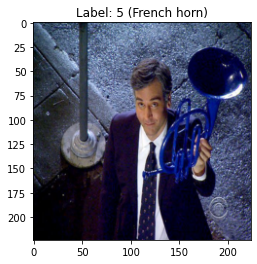

In [27]:
x, _ = next(iter(my_loader))
plot_image(x, 5)

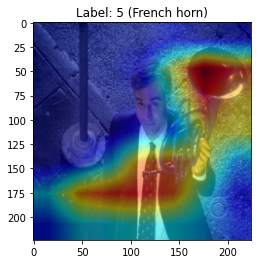

In [28]:
%%capture --no-display

x_gpu = x.to(device)
plot_gradcam(x_gpu, 5, cam)